In [25]:
# Importing the required files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [26]:
# Load the original dataset.
file_path = "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Datasets\\Darknet.csv"
darknet_data = pd.read_csv(file_path)

# **Model Pre-processing**

In [27]:
#  Process 1 - Filter TLS-related traffic.
tls_ports = [443, 993, 995, 465, 8443]
tls_traffic = darknet_data[
    (darknet_data['Dst Port'].isin(tls_ports)) &  # Destination port is TLS-related.
    (darknet_data['Protocol'] == 6)              # Protocol is TCP.
]

# Save filtered dataset for viewing purposes.
tls_traffic.to_csv("1. Filtered_TLS_Darknet.csv", index=False)
print("Filtered TLS dataset saved as 'Filtered_TLS_Darknet.csv'")

Filtered TLS dataset saved as 'Filtered_TLS_Darknet.csv'


In [28]:
#  Process 2 - Encoding the TLS traffic data.

# Creating object of Label Encoder class.
label_encoder = LabelEncoder()

# Encode string columns.
for column in tls_traffic.select_dtypes(include=['object']).columns:
    tls_traffic.loc[:, column] = label_encoder.fit_transform(tls_traffic[column])

# Save encoded dataset for viewing purposes.
tls_traffic.to_csv("2. Encoded_TLS_Darknet.csv", index=False)
print("Encoded TLS dataset saved as 'Encoded_TLS_Darknet.csv'")

Encoded TLS dataset saved as 'Encoded_TLS_Darknet.csv'


In [29]:
#  Process 3- Scaling the TLS traffic data.

# Step 1: Identify Numeric Columns to Scale.
# Exclude columns that should not be scaled.
columns_to_exclude = ['Protocol', 'Dst Port']  # Add any additional columns to exclude if needed.
numeric_columns = tls_traffic.select_dtypes(include=['float64', 'int64']).columns.difference(columns_to_exclude)

# Step 2: Check and Replace Invalid Values.
# Replace infinity values with NaN.
tls_traffic.loc[:, numeric_columns] = tls_traffic[numeric_columns].replace([np.inf, -np.inf], np.nan)

# Fill NaN values with column means.
tls_traffic.loc[:, numeric_columns] = tls_traffic[numeric_columns].fillna(tls_traffic[numeric_columns].mean())

# Step 3: Scale Only the Selected Numeric Columns.
scaler = MinMaxScaler()
tls_traffic.loc[:, numeric_columns] = scaler.fit_transform(tls_traffic[numeric_columns])

# Step 4: Save the Scaled Dataset for Viewing.
tls_traffic.to_csv("3. Scaled_TLS_Darknet.csv", index=False)
print("Scaled TLS dataset saved as 'Scaled_TLS_Darknet.csv'")

Scaled TLS dataset saved as 'Scaled_TLS_Darknet.csv'


# **Feature Selection and Feature Importance**

In [31]:
# Process 4 - Feature Selection.

# Define the target variable.
target_variable = 'Label'

# Calculate the correlation matrix.
correlation_matrix = tls_traffic.corr()

# Extract correlations with the target variable.
target_correlation = correlation_matrix[target_variable].drop(target_variable)

# Set a threshold for correlation (absolute value).
threshold = 0.1  # Adjust this based on your needs (e.g., 0.1 for weak correlation).

# Select features that are strongly correlated with the target.
selected_features = target_correlation[abs(target_correlation) > threshold]

# Remove identifier columns from the selected features.
identifiers = ['Flow ID', 'Src IP']
selected_features = selected_features.drop(index=identifiers, errors='ignore')

# Print the selected features and their correlation values.
print("Selected Features Based on Correlation with 'Label':")
print(selected_features)

# Update tls_traffic to retain only selected features and the target variable.
tls_traffic = tls_traffic[selected_features.index.tolist() + [target_variable]]

# Save the updated dataset for review.
tls_traffic.to_csv("4. Feature_Selected_Dataset_Without_Identifiers.csv", index=False)
print("Feature-selected dataset without identifiers saved as '4. Feature_Selected_Dataset_Without_Identifiers.csv'")

Selected Features Based on Correlation with 'Label':
Timestamp                -0.300921
Fwd Packet Length Mean    0.111124
Fwd PSH Flags             0.116855
SYN Flag Count           -0.177119
Fwd Segment Size Avg      0.111124
Subflow Fwd Packets       0.100899
FWD Init Win Bytes        0.295231
Bwd Init Win Bytes        0.269703
Fwd Seg Size Min          0.754610
Name: Label, dtype: float64
Feature-selected dataset without identifiers saved as '4. Feature_Selected_Dataset_Without_Identifiers.csv'


Feature Importance:
                  Feature  Importance
0               Timestamp    0.353997
8        Fwd Seg Size Min    0.236636
6      FWD Init Win Bytes    0.189628
7      Bwd Init Win Bytes    0.160596
1  Fwd Packet Length Mean    0.021654
4    Fwd Segment Size Avg    0.021053
3          SYN Flag Count    0.008305
2           Fwd PSH Flags    0.005236
5     Subflow Fwd Packets    0.002895


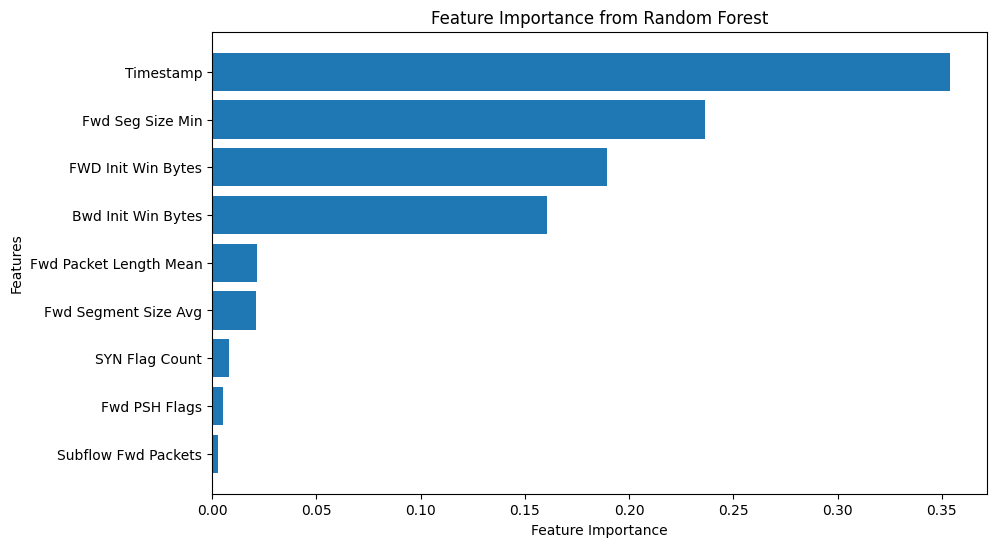

In [32]:
# Process 5 - Feature Importance validation.

# Ensure the target variable is properly encoded
tls_traffic['Label'] = tls_traffic['Label'].astype(int)  # Convert to integer if needed

# Separate features and target variable.
X = tls_traffic.drop(columns=['Label'])
y = tls_traffic['Label']

# Initialize and train the Random Forest model.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Calculate feature importance.
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualisation.
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print feature importance.
print("Feature Importance:")
print(feature_importance_df)

# Plot feature importance.
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# **Spliting Training and Testing Dataset**

In [33]:
# Process 6 - Splitting the dataset.
X = tls_traffic.drop(columns=['Label'])
y = tls_traffic['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training and testing datasets created.")

Training and testing datasets created.
